In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.regularizers import l1
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation

In [2]:
# Load and preprocess data
data = pd.read_excel("Final_data.xlsx")
data['Time'] = pd.to_datetime(data['Time'])

In [3]:
# Filter last two days of records for each sensor
last_two_days = data['Time'].max() - pd.Timedelta(days=2)
two_days_data = data[data['Time'] >= last_two_days]

In [4]:
last_two_days

Timestamp('2024-05-18 15:49:54')

In [5]:
two_days_data

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Anomaly,Date
4965,2024-05-19 11:42:32,25.65,48.4,047D6,047D6 T/RH IP67,0,2024-05-19
4966,2024-05-19 11:47:32,26.05,48.6,047D6,047D6 T/RH IP67,0,2024-05-19
4967,2024-05-19 11:52:32,26.55,46.3,047D6,047D6 T/RH IP67,0,2024-05-19
4968,2024-05-19 11:57:33,26.90,41.2,047D6,047D6 T/RH IP67,0,2024-05-19
4969,2024-05-19 12:02:33,26.95,43.2,047D6,047D6 T/RH IP67,0,2024-05-19
...,...,...,...,...,...,...,...
582104,2024-05-19 05:57:57,13.00,77.8,047CD,047CD T/RH IP67,0,2024-05-19
582105,2024-05-19 06:02:57,13.20,77.9,047CD,047CD T/RH IP67,0,2024-05-19
582106,2024-05-19 06:07:58,13.55,77.1,047CD,047CD T/RH IP67,0,2024-05-19
582107,2024-05-19 05:32:57,12.25,78.2,047CD,047CD T/RH IP67,0,2024-05-19


In [6]:
# Group by 'Sensor ID' and get the length of data for each sensor
sensor_data_length = two_days_data.groupby('Sensor ID').size()

# Display the results
print("Length of data for each sensor:")
print(sensor_data_length)

Length of data for each sensor:
Sensor ID
0474D    576
04750    576
04754    576
04756    576
04757    576
0475A    576
0475C    576
0475D    576
04762    576
04763    576
04765    575
04768    576
0476E    576
04771    576
04773    576
0477F    576
04787    576
04789    576
0478A    576
0478C    576
0478E    576
04791    576
04796    577
0479B    577
0479E    576
047A8    577
047AA    577
047AD    577
047B2    577
047B6    576
047B7    577
047B8    577
047BA    577
047BB    576
047BC    576
047C1    576
047C2    576
047C4    576
047C5    577
047C7    576
047C8    577
047C9    577
047CA    576
047CB    577
047CD    576
047CE    576
047D2    576
047D3    576
047D4    577
047D6    576
047D7    576
047DD    577
047F7    577
04802    576
04804    577
0480E    576
dtype: int64


In [7]:
# Check the number of unique sensors
unique_sensors_count = data['Sensor ID'].nunique()

print("\nTotal number of unique sensors:")
print(unique_sensors_count)


Total number of unique sensors:
56


In [8]:
# # Save results to a CSV file (optional)
# two_days_data.to_csv('Last_2_days.csv', index=False)

In [9]:
# Prepare features and labels
x = []
y = []
lags = 3  # Number of previous time steps to consider

sensor_ids = two_days_data['Sensor ID'].unique()
sensor_data_dict = {sensor_id: two_days_data[two_days_data['Sensor ID'] == sensor_id]['Temperature'].values for sensor_id in sensor_ids}

# Ensure all sensors have the same number of readings
min_length = min(len(data) for data in sensor_data_dict.values())

# Truncate to the minimum length
for sensor_id in sensor_ids:
    sensor_data_dict[sensor_id] = sensor_data_dict[sensor_id][:min_length]

# Create features and labels
for i in range(lags, min_length):
    features = []
    for sensor_id in sensor_ids:
        features.extend(sensor_data_dict[sensor_id][i-lags:i])
    x.append(features)
    y.append([sensor_data_dict[sensor_id][i] for sensor_id in sensor_ids])

In [10]:
x

[[25.65,
  26.05,
  26.55,
  15.7,
  15.8,
  15.85,
  14.75,
  14.75,
  14.8,
  13.15,
  12.85,
  12.55,
  20.95,
  20.05,
  19.75,
  23.6,
  24.2,
  24.9,
  16.4,
  16.45,
  16.55,
  15.0,
  14.9,
  14.75,
  14.55,
  14.6,
  14.7,
  13.25,
  12.9,
  12.55,
  33.8,
  33.9,
  19.0,
  19.2,
  19.3,
  19.25,
  25.85,
  28.3,
  29.3,
  16.0,
  22.45,
  22.55,
  13.15,
  13.1,
  13.05,
  12.9,
  12.65,
  12.4,
  33.8,
  33.7,
  33.65,
  33.45,
  33.3,
  33.15,
  28.4,
  27.85,
  27.25,
  29.2,
  32.1,
  34.7,
  33.35,
  29.85,
  29.6,
  19.05,
  19.2,
  19.3,
  29.1,
  28.6,
  28.6,
  16.3,
  16.3,
  16.25,
  29.6,
  29.25,
  12.4,
  13.4,
  13.05,
  12.8,
  29.7,
  29.65,
  30.1,
  28.0,
  16.9,
  16.9,
  23.95,
  24.5,
  25.95,
  25.65,
  26.65,
  27.13,
  30.2,
  30.8,
  31.45,
  29.2,
  24.85,
  24.4,
  15.15,
  15.2,
  15.25,
  13.6,
  13.7,
  13.7,
  25.2,
  26.55,
  27.8,
  15.6,
  15.7,
  15.85,
  25.4,
  20.3,
  20.05,
  29.95,
  29.9,
  11.85,
  33.95,
  33.7,
  34.0,
  30.85,
  3

In [11]:
y

[[26.9,
  15.9,
  14.85,
  12.35,
  19.65,
  25.8,
  16.65,
  14.5,
  14.8,
  12.35,
  19.45,
  19.15,
  28.7,
  22.15,
  12.95,
  12.2,
  32.9,
  33.15,
  27.25,
  33.76,
  29.55,
  19.35,
  28.0,
  16.2,
  12.2,
  12.55,
  12.0,
  16.8,
  27.2,
  26.6,
  31.15,
  23.6,
  15.3,
  13.7,
  27.7,
  15.95,
  19.9,
  11.75,
  33.55,
  32.1,
  19.75,
  23.45,
  34.75,
  12.2,
  30.05,
  12.2,
  15.8,
  16.5,
  16.65,
  12.4,
  15.3,
  15.95,
  31.1,
  29.4,
  16.7,
  17.15],
 [26.95,
  15.95,
  14.9,
  12.2,
  20.15,
  25.45,
  16.75,
  14.35,
  14.95,
  12.15,
  19.85,
  19.3,
  29.25,
  21.6,
  12.95,
  12.05,
  32.15,
  12.05,
  27.25,
  34.0,
  30.45,
  19.6,
  27.6,
  16.2,
  12.0,
  12.3,
  11.8,
  16.65,
  26.4,
  27.0,
  30.9,
  22.35,
  15.3,
  13.7,
  27.85,
  16.05,
  20.2,
  11.55,
  33.55,
  31.98,
  19.7,
  24.3,
  34.2,
  12.1,
  29.6,
  12.0,
  15.75,
  16.4,
  16.6,
  12.35,
  17.55,
  16.05,
  31.25,
  29.15,
  16.6,
  17.2],
 [27.0,
  16.0,
  14.95,
  12.05,
  20.85,
  25

In [12]:
x = np.array(x)
y = np.array(y)

In [13]:
# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [14]:
# Ensure x and y have the same number of samples
assert X_scaled.shape[0] == y_scaled.shape[0], "The number of samples in X and y do not match"

In [15]:
# Split data into training and validation sets
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras import regularizers


# Initialize the model
model = Sequential()

# Input layer
model.add(Input(shape=(X_scaled.shape[1],)))

# First Dense layer with BatchNormalization, Activation, and Dropout
model.add(Dense(128, kernel_regularizer=regularizers.l1_l2()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Add a few Dense layers with BatchNormalization, Activation, and Dropout
for _ in range(3):  # Reduced number of layers for simplicity
    model.add(Dense(128, kernel_regularizer=regularizers.l1_l2()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

# Output layer for 56 sensors
model.add(Dense(len(sensor_ids)))

In [17]:
# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [18]:
# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping])

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7053 - mae: 1.0619 - val_loss: 0.8977 - val_mae: 0.8387
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2076 - mae: 0.8937 - val_loss: 0.7252 - val_mae: 0.7403
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9162 - mae: 0.7730 - val_loss: 0.5904 - val_mae: 0.6467
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7717 - mae: 0.7070 - val_loss: 0.5048 - val_mae: 0.5864
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7223 - mae: 0.6837 - val_loss: 0.4383 - val_mae: 0.5410
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6552 - mae: 0.6469 - val_loss: 0.3849 - val_mae: 0.4992
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5993 - mae: 0.6205 - val_loss: 0.3446 - val_mae: 0.4661
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5529 - mae: 0.5918 - val_loss: 0.3118 - val_mae: 0.4391
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.513

In [19]:
# Save the trained model
pkl.dump(model, open('S_P_model.pkl', 'wb'))

# Load the model back
MLP_model = pkl.load(open('S_P_model.pkl', 'rb'))

In [20]:
# Evaluate the model on the entire dataset
loss = MLP_model.evaluate(X_scaled, y_scaled)
print(f"Model Loss on Entire Dataset: {loss}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.0829 - mae: 0.1866
Model Loss on Entire Dataset: [0.08920864760875702, 0.19185590744018555]


In [21]:
# Prepare the input for prediction: the latest temperature readings for each sensor
latest_inputs = []
actual_temps = []

for sensor_id in sensor_ids:
    sensor_data = sensor_data_dict[sensor_id]
    latest_input = sensor_data[-lags:]
    actual_temp = sensor_data[-1]  # Actual next temperature
    latest_inputs.extend(latest_input)
    actual_temps.append(actual_temp)

latest_inputs = np.array(latest_inputs).reshape(1, -1)
latest_inputs_scaled = scaler_X.transform(latest_inputs)

In [115]:
latest_inputs.shape
# len(latest_inputs)

array([[20.35, 20.05, 19.85, 25.25, 22.15, 19.9 , 23.25, 23.95, 24.59,
        16.65, 16.7 , 16.65, 27.15, 25.6 , 24.55, 29.05, 29.45, 30.3 ,
        31.75, 31.9 , 31.75, 26.75, 25.85, 26.35, 13.05, 13.05, 13.1 ,
        16.25, 16.25, 16.3 , 29.  , 26.95, 25.05, 30.4 , 30.4 , 30.15,
        22.5 , 20.7 , 32.9 , 28.4 , 27.8 , 25.25, 16.75, 16.7 , 16.65,
        16.25, 16.25, 16.3 , 32.7 , 32.65, 32.75, 16.25, 16.3 , 16.35,
        23.45, 22.75, 22.1 , 28.8 , 27.5 , 25.35, 16.35, 16.3 , 16.25,
        30.75, 31.4 , 32.3 , 23.95, 22.15, 29.35, 12.55, 11.45, 30.25,
        16.2 , 16.2 , 16.3 , 16.1 , 16.05, 16.1 , 16.3 , 16.3 , 16.4 ,
        11.9 , 12.15, 11.3 , 32.95, 31.35, 32.  , 26.3 , 25.7 , 26.95,
        12.1 , 12.15, 12.15, 15.3 , 15.25, 15.25, 31.4 , 31.55, 30.35,
        17.  , 17.15, 17.3 , 25.25, 26.05, 22.1 , 31.85, 31.75, 33.85,
        23.95, 24.1 , 23.8 , 16.25, 16.3 , 16.  , 26.8 , 28.65, 28.9 ,
        15.55, 15.5 , 15.4 , 30.9 , 30.85, 31.35, 28.6 , 28.15, 28.1 ,
      

In [23]:
actual_temps

[19.85,
 19.9,
 24.59,
 16.65,
 24.55,
 30.3,
 31.75,
 26.35,
 13.1,
 16.3,
 25.05,
 30.15,
 32.9,
 25.25,
 16.65,
 16.3,
 32.75,
 16.35,
 22.1,
 25.35,
 16.25,
 32.3,
 29.35,
 30.25,
 16.3,
 16.1,
 16.4,
 11.3,
 32.0,
 26.95,
 12.15,
 15.25,
 30.35,
 17.3,
 22.1,
 33.85,
 23.8,
 16.0,
 28.9,
 15.4,
 31.35,
 28.1,
 15.7,
 16.3,
 14.4,
 16.05,
 15.1,
 30.0,
 12.85,
 16.55,
 15.5,
 33.85,
 19.8,
 33.4,
 31.95,
 12.25]

In [24]:
# Predict the next temperature for each sensor
predictions_scaled = MLP_model.predict(latest_inputs_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [25]:
len(predictions)

1

In [26]:
# Calculate the error (MAE)
errors = np.abs(predictions.flatten() - np.array(actual_temps))

In [27]:
# Create a DataFrame to display the predictions, actual values, and errors
predictions_df = pd.DataFrame({
    'Sensor ID': sensor_ids,
    'Predicted Temperature': predictions.flatten(),
    'Actual Temperature': actual_temps,
    'Error (MAE)': errors
})

In [28]:
# Check the lengths of the arrays used in the DataFrame
len_sensor_ids = len(sensor_ids)
len_predictions = len(predictions.flatten())
len_actual_temps = len(actual_temps)
len_errors = len(errors)

(len_sensor_ids, len_predictions, len_actual_temps, len_errors)

(56, 56, 56, 56)

In [29]:
print(predictions_df)

   Sensor ID  Predicted Temperature  Actual Temperature  Error (MAE)
0      047D6              20.322041               19.85     0.472041
1      0475D              23.694735               19.90     3.794735
2      0479B              24.402393               24.59     0.187607
3      047BB              16.724625               16.65     0.074625
4      04754              20.102270               24.55     4.447730
5      047CE              28.907215               30.30     1.392785
6      047CB              31.092201               31.75     0.657799
7      0474D              26.369106               26.35     0.019106
8      04757              11.999749               13.10     1.100251
9      047AA              16.836065               16.30     0.536065
10     047C2              19.386929               25.05     5.663071
11     047F7              31.754152               30.15     1.604152
12     04756              24.973883               32.90     7.926117
13     047C1              21.00775

In [30]:
# Normalize the loss values for plotting
loss_values = history.history['loss']
min_loss = np.min(loss_values)
max_loss = np.max(loss_values)
normalized_loss = (loss_values - min_loss) / (max_loss - min_loss)

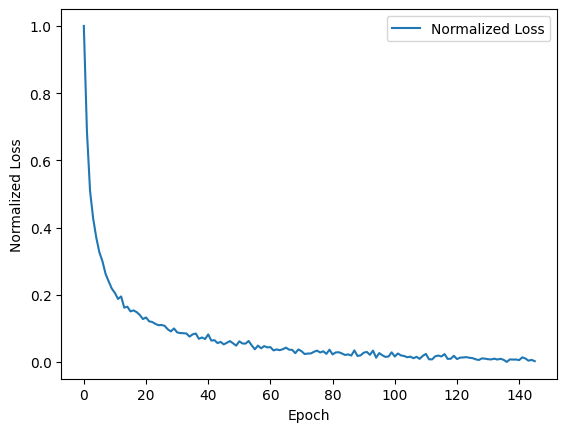

In [31]:
import matplotlib.pyplot as plt

# Plot the normalized loss values
plt.plot(normalized_loss, label='Normalized Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()
plt.show()

In [32]:
# Heatmap plot for predicted, actual, and error values
selected_sensors_list = list(data['Sensor ID'].unique())
predictions_df['Sensor ID'] = pd.Categorical(predictions_df['Sensor ID'], categories=selected_sensors_list, ordered=True)
predictions_df_sorted = predictions_df.sort_values(by='Sensor ID')
predictions_df_sorted = predictions_df_sorted[~pd.isna(predictions_df_sorted['Sensor ID'])]
predictions_df_sorted['Sensor ID'] = predictions_df_sorted['Sensor ID'].astype(str)
predictions_df_sorted.reset_index(drop=True, inplace=True)

In [33]:
# Reshape into 8x7 (assuming you have 56 sensors and this is your layout)
predicted = np.array(predictions_df_sorted['Predicted Temperature']).reshape(8, 7)
actual = np.array(predictions_df_sorted['Actual Temperature']).reshape(8, 7)
error = np.array(predictions_df_sorted['Error (MAE)']).reshape(8, 7)

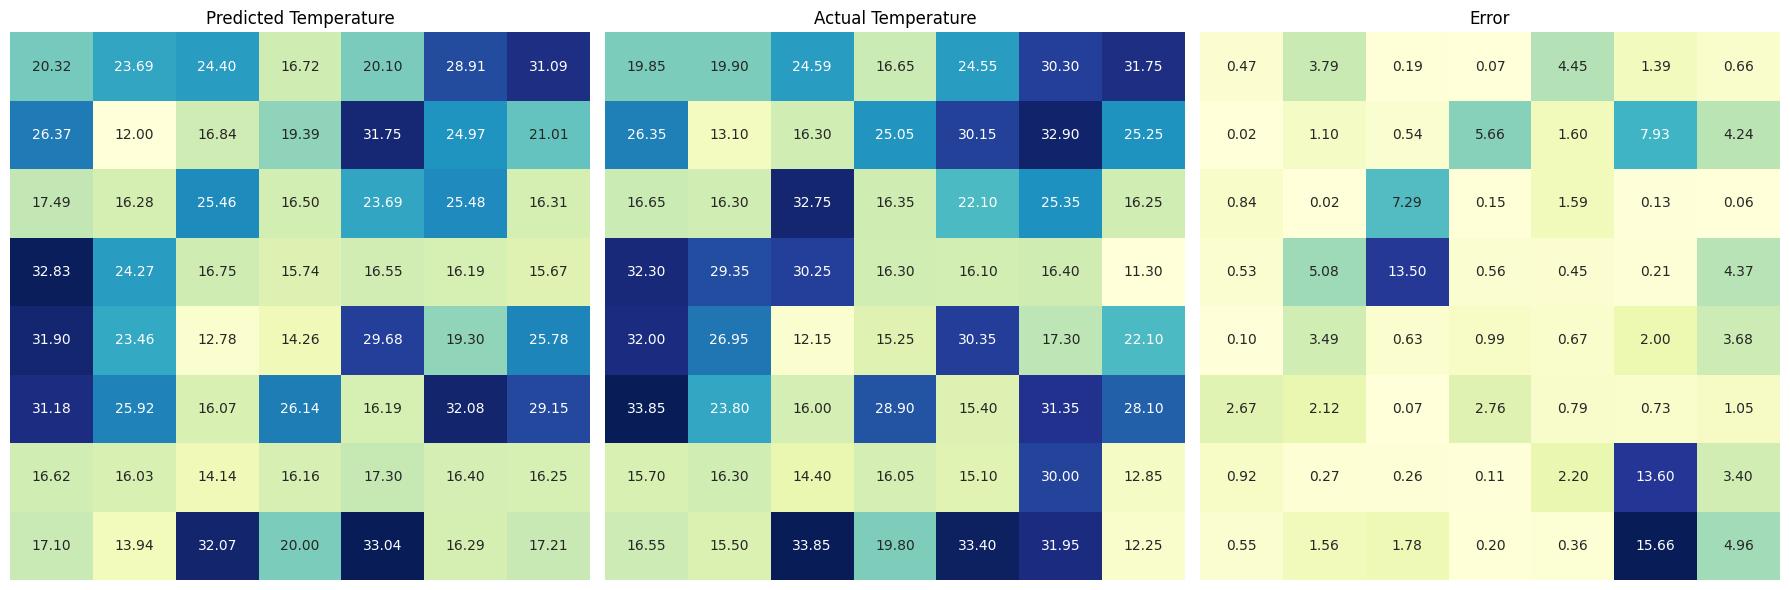

In [34]:
import seaborn as sns

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot heatmaps
sns.heatmap(predicted, ax=axes[0], cmap='YlGnBu', annot=True, fmt='.2f', cbar=False, xticklabels=False, yticklabels=False)
axes[0].set_title('Predicted Temperature')

sns.heatmap(actual, ax=axes[1], cmap='YlGnBu', annot=True, fmt='.2f', cbar=False, xticklabels=False, yticklabels=False)
axes[1].set_title('Actual Temperature')

sns.heatmap(error, ax=axes[2], cmap='YlGnBu', annot=True, fmt='.2f', cbar=False, xticklabels=False, yticklabels=False)
axes[2].set_title('Error')

# Adjust layout
plt.tight_layout()
plt.show()

## Temperature sensor pruning :

In [35]:
def prune_input_neurons_by_percentage(model, layer_index, percentage, num_sensors, lags, already_pruned):
    """
    Prunes the input neurons by removing a specified percentage of the lowest weights, excluding already pruned sensors.

    Args:
    - model: The Keras model.
    - layer_index: The index of the input layer.
    - percentage: The percentage of neurons to prune based on the lowest weights.
    - num_sensors: The number of sensors.
    - lags: The number of previous time steps considered.
    - already_pruned: List of indices of already pruned sensors.

    Returns:
    - prune_indices: List of indices of sensors pruned in this iteration.
    """
    layer = model.layers[layer_index]
    weights, biases = layer.get_weights()

    # Compute L1 norm of each sensor (based on the grouped weights)
    neuron_norms = np.array([np.sum(np.abs(weights[i*lags:(i+1)*lags, :])) for i in range(num_sensors)])
    
    # Exclude already pruned sensors by setting their norms to infinity
    neuron_norms[already_pruned] = np.inf
    
    # Determine the number of sensors to prune
    num_to_prune = int(len(neuron_norms) * percentage)
    
    # Identify the indices of sensors with the lowest norms
    prune_indices = np.argsort(neuron_norms)[:num_to_prune]
    
    print(f"Pruning {num_to_prune} sensors out of {len(neuron_norms)}")
    print(f"Dropped Sensors at indices: {prune_indices.tolist()}")

    # Drop sensors by setting their weights and biases to zero
    for sensor_index in prune_indices:
        weights[sensor_index*lags:(sensor_index+1)*lags, :] = 0
    layer.set_weights([weights, biases])

    return prune_indices

In [36]:
def adaptive_pruning_input_by_performance(model, layer_index, initial_percentage, num_sensors, lags, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, max_epochs=5, performance_threshold=0.01):
    already_pruned = []
    pruning_percentage = initial_percentage
    previous_val_loss = None
    
    for epoch in range(max_epochs):
        print(f"Epoch {epoch + 1}/{max_epochs}: Pruning with {pruning_percentage*100}% of lowest weight sensors")

        # Prune based on the current percentage
        new_dropped_sensors = prune_input_neurons_by_percentage(model, layer_index, pruning_percentage, num_sensors, lags, already_pruned)
        already_pruned.extend(new_dropped_sensors)

        if len(new_dropped_sensors) > 0:
            # Retrain the model after pruning
            model.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
            history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=128, validation_data=(X_val_scaled, y_val_scaled), verbose=0)
            
            # Evaluate model performance
            val_loss = model.evaluate(X_val_scaled, y_val_scaled, verbose=0)
            print(f"Validation Loss after pruning: {val_loss}")
            
            # Adjust pruning percentage based on performance
            if previous_val_loss is not None:
                if val_loss < previous_val_loss:  # If performance improves, increase pruning rate
                    pruning_percentage = min(pruning_percentage * 1.2, 0.5)  # Cap the percentage to 50%
                elif (val_loss - previous_val_loss) / previous_val_loss < performance_threshold:  # Small performance drop, keep pruning rate the same
                    pruning_percentage = pruning_percentage  # No change
                else:  # Significant performance drop, decrease pruning rate
                    pruning_percentage = max(pruning_percentage * 0.7, 0.01)  # Do not allow pruning percentage to drop below 1%
            previous_val_loss = val_loss

            print(f"Adjusted pruning percentage: {pruning_percentage*100}%")
            
        else:
            print("No more sensors to prune in this epoch.")
            break

    return model, already_pruned


In [37]:
# Set initial pruning percentage and apply adaptive pruning
initial_pruning_percentage = 0.1  # Start with 10%
pruning_model, dropped_input_neurons = adaptive_pruning_input_by_performance(
    model,
    layer_index=0, 
    initial_percentage=initial_pruning_percentage, 
    num_sensors=len(sensor_ids), 
    lags=lags,
    X_train_scaled=X_train_scaled,
    y_train_scaled=y_train_scaled,
    X_val_scaled=X_val_scaled,
    y_val_scaled=y_val_scaled,
    max_epochs=5,  # Maximum number of pruning epochs
    performance_threshold=0.01  # Performance change threshold for adjustment
)

Epoch 1/5: Pruning with 10.0% of lowest weight sensors
Pruning 5 sensors out of 56
Dropped Sensors at indices: [3, 26, 9, 24, 17]
Validation Loss after pruning: 0.10709571093320847
Adjusted pruning percentage: 10.0%
Epoch 2/5: Pruning with 10.0% of lowest weight sensors
Pruning 5 sensors out of 56
Dropped Sensors at indices: [48, 6, 43, 47, 27]
Validation Loss after pruning: 0.10046415030956268
Adjusted pruning percentage: 12.0%
Epoch 3/5: Pruning with 12.0% of lowest weight sensors
Pruning 6 sensors out of 56
Dropped Sensors at indices: [25, 10, 36, 15, 39, 20]
Validation Loss after pruning: 0.09464865177869797
Adjusted pruning percentage: 14.399999999999999%
Epoch 4/5: Pruning with 14.399999999999999% of lowest weight sensors
Pruning 8 sensors out of 56
Dropped Sensors at indices: [13, 40, 28, 11, 44, 32, 14, 0]
Validation Loss after pruning: 0.09551472961902618
Adjusted pruning percentage: 14.399999999999999%
Epoch 5/5: Pruning with 14.399999999999999% of lowest weight sensors
Pruni

In [38]:
print(f"Total Number of Dropped Sensors: {len(dropped_input_neurons)}")
print(f"List of Dropped Sensors: {dropped_input_neurons}")

Total Number of Dropped Sensors: 32
List of Dropped Sensors: [3, 26, 9, 24, 17, 48, 6, 43, 47, 27, 25, 10, 36, 15, 39, 20, 13, 40, 28, 11, 44, 32, 14, 0, 16, 45, 22, 52, 54, 35, 12, 19]


In [39]:
# After pruning, evaluate the model using the entire dataset
pruned_loss = pruning_model.evaluate(X_scaled, y_scaled)
print(f"Model Loss on Entire Dataset after Pruning: {pruned_loss}")

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0388

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0641
Model Loss on Entire Dataset after Pruning: 0.0684354230761528


In [40]:
# Calculate retained sensor IDs by excluding the pruned sensors
all_sensor_ids = list(sensor_ids)  # Original list of sensor IDs
dropped_sensor_ids = [all_sensor_ids[idx] for idx in dropped_input_neurons]  # Map the indices to sensor IDs


In [41]:
# Define retained_sensor_ids by excluding dropped_sensor_ids
retained_sensor_ids = [sensor_id for sensor_id in all_sensor_ids if sensor_id not in dropped_sensor_ids]

In [42]:
retained_sensor_ids

['0475D',
 '0479B',
 '04754',
 '047CE',
 '0474D',
 '04757',
 '04773',
 '047B8',
 '0480E',
 '04804',
 '04763',
 '047B6',
 '047D2',
 '04765',
 '0478C',
 '047D4',
 '047C7',
 '047CA',
 '04787',
 '0475A',
 '04771',
 '04791',
 '047C5',
 '047CD']

In [43]:
len(retained_sensor_ids)

24

## Humidity :

In [44]:
# Prepare features and labels
a = []
b = []
lags = 3  # Number of previous time steps to consider

sensor_ids = two_days_data['Sensor ID'].unique()
sensor_data_dict = {sensor_id: two_days_data[two_days_data['Sensor ID'] == sensor_id]['Humidity'].values for sensor_id in sensor_ids}

# Ensure all sensors have the same number of readings
min_length = min(len(data) for data in sensor_data_dict.values())

# Truncate to the minimum length
for sensor_id in sensor_ids:
    sensor_data_dict[sensor_id] = sensor_data_dict[sensor_id][:min_length]

# Create features and labels
for i in range(lags, min_length):
    features = []
    for sensor_id in sensor_ids:
        features.extend(sensor_data_dict[sensor_id][i-lags:i])
    a.append(features)
    b.append([sensor_data_dict[sensor_id][i] for sensor_id in sensor_ids])

In [45]:
a = np.array(a)
b = np.array(b)

# Normalize the data
scaler_A = StandardScaler()
scaler_b = StandardScaler()
A_scaled = scaler_A.fit_transform(a)
b_scaled = scaler_b.fit_transform(b)
# Ensure x and y have the same number of samples
assert A_scaled.shape[0] == b_scaled.shape[0], "The number of samples in X and y do not match"
# Split data into training and validation sets
A_train_scaled, A_val_scaled, b_train_scaled, b_val_scaled = train_test_split(A_scaled, b_scaled, test_size=0.2, random_state=42)

In [46]:
from tensorflow.keras import regularizers


# Initialize the model
humid_model = Sequential()

# Input layer
humid_model.add(Input(shape=(A_scaled.shape[1],)))

# First Dense layer with BatchNormalization, Activation, and Dropout
humid_model.add(Dense(128, kernel_regularizer=regularizers.l1_l2()))
humid_model.add(BatchNormalization())
humid_model.add(Activation('relu'))
humid_model.add(Dropout(0.2))

# Add a few Dense layers with BatchNormalization, Activation, and Dropout
for _ in range(3):  # Reduced number of layers for simplicity
    humid_model.add(Dense(128, kernel_regularizer=regularizers.l1_l2()))
    humid_model.add(BatchNormalization())
    humid_model.add(Activation('relu'))
    humid_model.add(Dropout(0.2))

# Output layer for 56 sensors
humid_model.add(Dense(len(sensor_ids)))

In [47]:
# Compile the model
humid_model.compile(optimizer=Nadam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = humid_model.fit(A_train_scaled, b_train_scaled, epochs=200, batch_size=32, validation_data=(A_val_scaled, b_val_scaled), callbacks=[early_stopping])

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7096 - mae: 1.0651 - val_loss: 0.9146 - val_mae: 0.8535
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1825 - mae: 0.8895 - val_loss: 0.7459 - val_mae: 0.7615
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9405 - mae: 0.7859 - val_loss: 0.6019 - val_mae: 0.6630
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8032 - mae: 0.7248 - val_loss: 0.5139 - val_mae: 0.5974
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7049 - mae: 0.6753 - val_loss: 0.4519 - val_mae: 0.5495
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6362 - mae: 0.6392 - val_loss: 0.4021 - val_mae: 0.5125
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5813 - mae: 0.6078 - val_loss: 0.3631 - val_mae: 0.4818
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5681 - mae: 0.6007 - val_loss: 0.3372 - val_mae: 0.4614
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.529

In [48]:
# Save the trained model
pkl.dump(humid_model, open('S_P_model_H.pkl', 'wb'))

# Load the model back
MLP_humid_model = pkl.load(open('S_P_model_H.pkl', 'rb'))

In [49]:
# Evaluate the model on the entire dataset
loss = MLP_humid_model.evaluate(A_scaled, b_scaled)
print(f"Model Loss on Entire Dataset: {loss}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 0.0959 - mae: 0.2067
Model Loss on Entire Dataset: [0.10186007618904114, 0.21124497056007385]


In [50]:
# Prepare the input for prediction: the latest Humidity readings for each sensor
latest_humid_inputs = []
actual_humids = []

for sensor_id in sensor_ids:
    sensor_data = sensor_data_dict[sensor_id]
    latest_h_input = sensor_data[-lags:]
    actual_humid = sensor_data[-1]  # Actual next Humidity
    latest_humid_inputs.extend(latest_h_input)
    actual_humids.append(actual_humid)

latest_humid_inputs = np.array(latest_humid_inputs).reshape(1, -1)
latest_humid_scaled = scaler_A.transform(latest_humid_inputs)

In [51]:
# Predict the next Humidity for each sensor
predictions_scaled = MLP_humid_model.predict(latest_humid_scaled)
predictions_humid = scaler_b.inverse_transform(predictions_scaled)

# Calculate the error (MAE)
errors_humid = np.abs(predictions_humid.flatten() - np.array(actual_humids))

# Create a DataFrame to display the predictions, actual values, and errors
predictions_humid_df = pd.DataFrame({
    'Sensor ID': sensor_ids,
    'Predicted Humidity': predictions_humid.flatten(),
    'Actual Humidity': actual_humids,
    'Error (MAE)': errors_humid
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


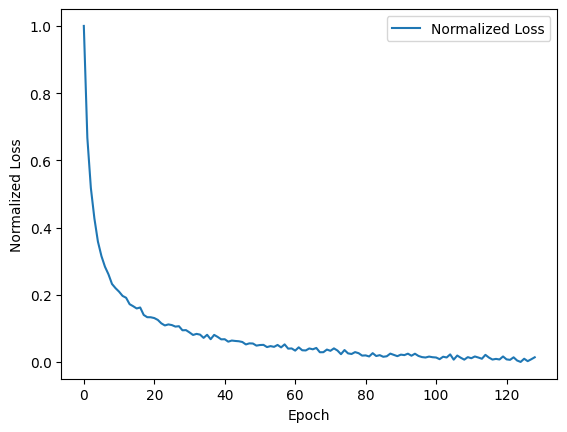

In [52]:
# Check the lengths of the arrays used in the DataFrame
len__humid_sensor = len(sensor_ids)
len_predictions_humid = len(predictions_humid.flatten())
len_actual_humids = len(actual_humids)
len_errors_humid = len(errors_humid)

(len__humid_sensor, len_predictions_humid, len_actual_humids, len_errors_humid)
# Normalize the loss values for plotting
loss_values = history.history['loss']
min_loss = np.min(loss_values)
max_loss = np.max(loss_values)
normalized_loss = (loss_values - min_loss) / (max_loss - min_loss)
import matplotlib.pyplot as plt

# Plot the normalized loss values
plt.plot(normalized_loss, label='Normalized Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()
plt.show()

In [53]:
# Heatmap plot for predicted, actual, and error values
selected_sensors_list = list(data['Sensor ID'].unique())
predictions_humid_df['Sensor ID'] = pd.Categorical(predictions_humid_df['Sensor ID'], categories=selected_sensors_list, ordered=True)
predictions_humid_df_sorted = predictions_humid_df.sort_values(by='Sensor ID')
predictions_humid_df_sorted = predictions_humid_df_sorted[~pd.isna(predictions_humid_df_sorted['Sensor ID'])]
predictions_humid_df_sorted['Sensor ID'] = predictions_humid_df_sorted['Sensor ID'].astype(str)
predictions_humid_df_sorted.reset_index(drop=True, inplace=True)

In [54]:
# Reshape into 8x7 (assuming you have 56 sensors and this is your layout)
predicted = np.array(predictions_humid_df_sorted['Predicted Humidity']).reshape(8, 7)
actual = np.array(predictions_humid_df_sorted['Actual Humidity']).reshape(8, 7)
error = np.array(predictions_humid_df_sorted['Error (MAE)']).reshape(8, 7)

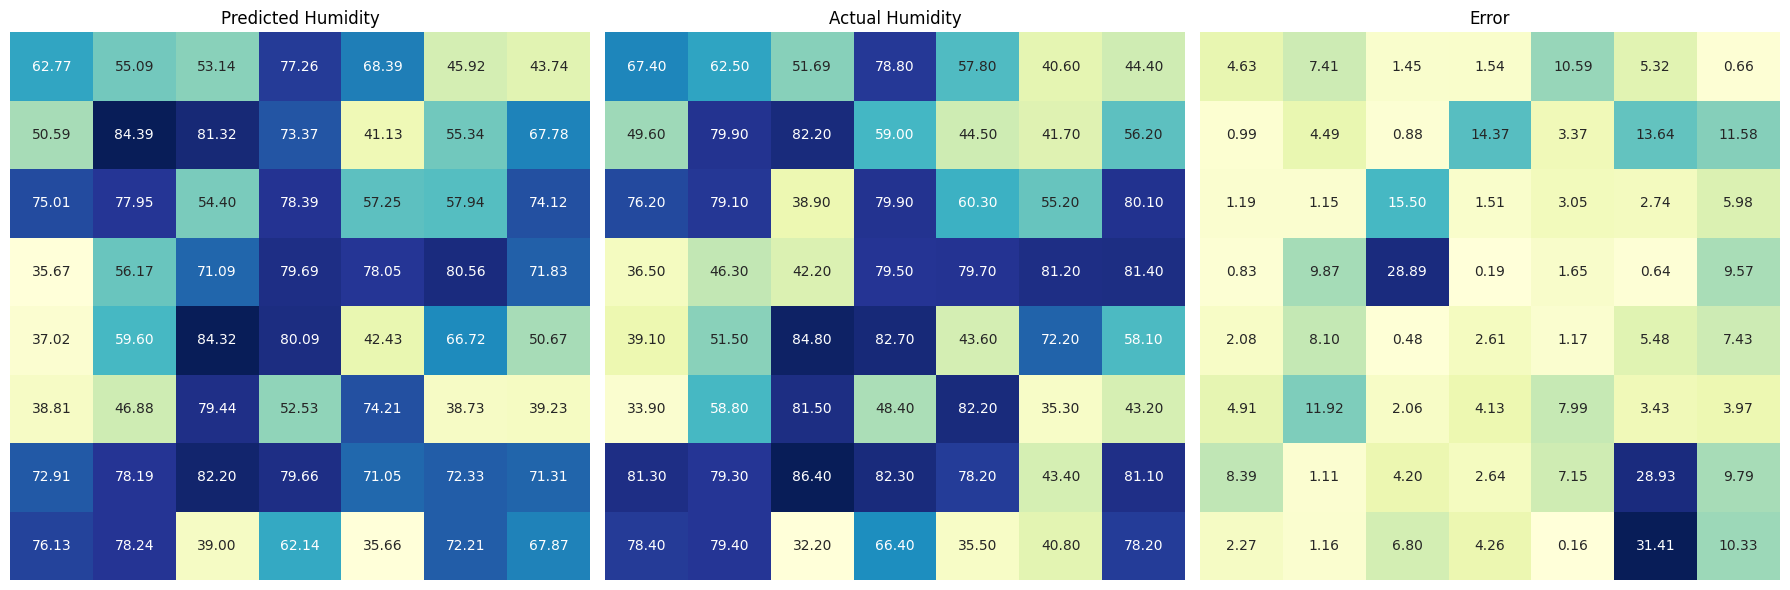

In [55]:
import seaborn as sns

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot heatmaps
sns.heatmap(predicted, ax=axes[0], cmap='YlGnBu', annot=True, fmt='.2f', cbar=False, xticklabels=False, yticklabels=False)
axes[0].set_title('Predicted Humidity')

sns.heatmap(actual, ax=axes[1], cmap='YlGnBu', annot=True, fmt='.2f', cbar=False, xticklabels=False, yticklabels=False)
axes[1].set_title('Actual Humidity')

sns.heatmap(error, ax=axes[2], cmap='YlGnBu', annot=True, fmt='.2f', cbar=False, xticklabels=False, yticklabels=False)
axes[2].set_title('Error')

# Adjust layout
plt.tight_layout()
plt.show()

## Humidity sensor pruning :

In [56]:
# Set initial pruning percentage and apply adaptive pruning
initial_pruning_percentage = 0.1  # Start with 10%
pruning_model, dropped_input_neurons = adaptive_pruning_input_by_performance(
    humid_model,
    layer_index=0, 
    initial_percentage=initial_pruning_percentage, 
    num_sensors=len(sensor_ids), 
    lags=lags,
    X_train_scaled=A_train_scaled,
    y_train_scaled=b_train_scaled,
    X_val_scaled=A_val_scaled,
    y_val_scaled=b_val_scaled,
    max_epochs=5,  # Maximum number of pruning epochs
    performance_threshold=0.01  # Performance change threshold for adjustment
)

print(f"Total Number of Dropped Sensors: {len(dropped_input_neurons)}")
print(f"List of Dropped Sensors: {dropped_input_neurons}")
# After pruning, evaluate the model using the entire dataset
pruned_loss = pruning_model.evaluate(A_scaled, b_scaled)
print(f"Model Loss on Entire Dataset after Pruning: {pruned_loss}")
# Calculate retained sensor IDs by excluding the pruned sensors
all_sensor_ids = list(sensor_ids)  # Original list of sensor IDs
dropped_sensor_Humid = [all_sensor_ids[idx] for idx in dropped_input_neurons]  # Map the indices to sensor IDs

# Define retained_sensor_ids by excluding dropped_sensor_ids
retained_sensor_Humid = [sensor_id for sensor_id in all_sensor_ids if sensor_id not in dropped_sensor_ids]

Epoch 1/5: Pruning with 10.0% of lowest weight sensors
Pruning 5 sensors out of 56
Dropped Sensors at indices: [9, 22, 11, 49, 25]
Validation Loss after pruning: 0.12017960846424103
Adjusted pruning percentage: 10.0%
Epoch 2/5: Pruning with 10.0% of lowest weight sensors
Pruning 5 sensors out of 56
Dropped Sensors at indices: [48, 17, 20, 3, 16]
Validation Loss after pruning: 0.11337331682443619
Adjusted pruning percentage: 12.0%
Epoch 3/5: Pruning with 12.0% of lowest weight sensors
Pruning 6 sensors out of 56
Dropped Sensors at indices: [10, 39, 6, 7, 54, 50]
Validation Loss after pruning: 0.109364353120327
Adjusted pruning percentage: 14.399999999999999%
Epoch 4/5: Pruning with 14.399999999999999% of lowest weight sensors
Pruning 8 sensors out of 56
Dropped Sensors at indices: [24, 47, 27, 44, 15, 14, 41, 40]
Validation Loss after pruning: 0.10509738326072693
Adjusted pruning percentage: 17.279999999999998%
Epoch 5/5: Pruning with 17.279999999999998% of lowest weight sensors
Pruning

In [57]:
retained_sensor_Humid

['0475D',
 '0479B',
 '04754',
 '047CE',
 '0474D',
 '04757',
 '04773',
 '047B8',
 '0480E',
 '04804',
 '04763',
 '047B6',
 '047D2',
 '04765',
 '0478C',
 '047D4',
 '047C7',
 '047CA',
 '04787',
 '0475A',
 '04771',
 '04791',
 '047C5',
 '047CD']

In [58]:
retained_sensor_ids

['0475D',
 '0479B',
 '04754',
 '047CE',
 '0474D',
 '04757',
 '04773',
 '047B8',
 '0480E',
 '04804',
 '04763',
 '047B6',
 '047D2',
 '04765',
 '0478C',
 '047D4',
 '047C7',
 '047CA',
 '04787',
 '0475A',
 '04771',
 '04791',
 '047C5',
 '047CD']

In [59]:
# Finding the common elements
common_sensors = list(set(retained_sensor_ids) & set(retained_sensor_Humid))
common_sensors

['0478C',
 '047B8',
 '04791',
 '0479B',
 '0475A',
 '04773',
 '0480E',
 '0474D',
 '04804',
 '047C7',
 '047C5',
 '047D4',
 '047CD',
 '04765',
 '047CE',
 '04787',
 '04757',
 '04754',
 '047CA',
 '047D2',
 '0475D',
 '04771',
 '047B6',
 '04763']

## Error calicultions with retained sensors :

### Temperature

In [60]:
import json

with open('sensor_placement.json','r') as sensor:
    data = json.load(sensor)


In [61]:
reduced_sensor_data = pd.read_excel("Final_data.xlsx")

In [62]:
reduced_sensor_data['Time'] = pd.to_datetime(reduced_sensor_data['Time'])

In [63]:
reduced_sensor_data['Time'][0]

Timestamp('2024-05-10 03:41:57')

In [64]:
not_reduced_sensor_data = reduced_sensor_data[~reduced_sensor_data['Sensor ID'].isin(common_sensors)]

In [65]:
not_reduced_sensor_data['Sensor ID'].unique()

array(['047D6', '047BB', '047CB', '047AA', '047C2', '047F7', '04756',
       '047C1', '0478A', '04762', '04768', '04789', '047B7', '047D3',
       '04750', '047DD', '047D7', '047A8', '047BA', '047B2', '047C4',
       '047C8', '0477F', '0479E', '047C9', '0476E', '0478E', '0475C',
       '047AD', '047BC', '04802', '04796'], dtype=object)

In [66]:
reduced_sensors = reduced_sensor_data[reduced_sensor_data['Sensor ID'].isin(common_sensors)]

In [67]:
reduced_sensors['Sensor ID'].unique()

array(['0475D', '0479B', '04754', '047CE', '0474D', '04757', '04773',
       '047B8', '0480E', '04804', '04763', '047B6', '047D2', '04765',
       '0478C', '047D4', '047C7', '047CA', '04787', '0475A', '04771',
       '04791', '047C5', '047CD'], dtype=object)

In [68]:
# Convert 'Time' column to datetime if not already done
reduced_sensor_data['Time'] = pd.to_datetime(reduced_sensor_data['Time'])

# Extract the month from the 'Time' column and create a 'Month' column
reduced_sensor_data['Month'] = reduced_sensor_data['Time'].dt.month
# reduced_sensor_data['Year'] = reduced_sensor_data['Time'].dt.year

# Get the latest date in the dataset
latest_date = reduced_sensor_data['Time'].max()

# Extract the latest month
latest_month = latest_date.month
# latest_year = latest_date.year

# Filter the DataFrame for the latest month
latest_month_data_1 = reduced_sensor_data[ reduced_sensor_data['Month'] == latest_month]

# Proceed with your other operations
sample_dataset_1 = latest_month_data_1.groupby('Sensor ID', observed=False).apply(lambda x: x.tail(10000)).reset_index(drop=True)

# Use .loc to avoid SettingWithCopyWarning
sample_dataset_1['Sensor ID'] = pd.Categorical(sample_dataset_1['Sensor ID'], categories=list(data.keys()), ordered=True)
reduced_df_sorted_1 = sample_dataset_1.sort_values(by='Sensor ID')
reduced_df_sorted_1 = reduced_df_sorted_1[~pd.isna(reduced_df_sorted_1['Sensor ID'])]
reduced_df_sorted_1['Sensor ID'] = reduced_df_sorted_1['Sensor ID'].astype(str)
reduced_df_sorted_1.reset_index(drop=True, inplace=True)


/var/folders/sd/6m81mt411jxfsqsc4d3ctrg40000gn/T/ipykernel_19272/2692034216.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_dataset_1 = latest_month_data_1.groupby('Sensor ID', observed=False).apply(lambda x: x.tail(10000)).reset_index(drop=True)


In [69]:
reduced_df_sorted_1

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Anomaly,Date,Month
0,2024-05-10 03:41:57,10.85,83.2,047D6,047D6 T/RH IP67,0,2024-05-10,5
1,2024-05-09 06:47:53,12.80,80.5,047D6,047D6 T/RH IP67,0,2024-05-09,5
2,2024-05-09 06:42:54,12.25,81.8,047D6,047D6 T/RH IP67,0,2024-05-09,5
3,2024-05-09 06:37:54,11.85,82.0,047D6,047D6 T/RH IP67,0,2024-05-09,5
4,2024-05-09 06:32:54,11.45,83.0,047D6,047D6 T/RH IP67,0,2024-05-09,5
...,...,...,...,...,...,...,...,...
317232,2024-05-13 07:47:48,15.70,76.3,047CD,047CD T/RH IP67,0,2024-05-13,5
317233,2024-05-13 06:22:51,14.30,74.2,047CD,047CD T/RH IP67,0,2024-05-13,5
317234,2024-05-13 06:12:51,14.20,73.3,047CD,047CD T/RH IP67,0,2024-05-13,5
317235,2024-05-13 10:07:43,19.55,75.2,047CD,047CD T/RH IP67,0,2024-05-13,5


In [70]:
# Convert 'Time' column to datetime
reduced_sensors.loc[:, 'Time'] = pd.to_datetime(reduced_sensors['Time'])

# Extract the month from the 'Time' column and create a 'Month' column
reduced_sensors['Month'] = reduced_sensors['Time'].dt.month
# reduced_sensors['Year'] = reduced_sensors['Time'].dt.year

# Get the latest date in the dataset
latest_date = reduced_sensors['Time'].max()

# Extract the latest month and year
latest_month = latest_date.month
# latest_year = latest_date.year

# Filter the DataFrame for the latest month and year
latest_month_data = reduced_sensors[(reduced_sensors['Month'] == latest_month)]

sample_dataset = latest_month_data.groupby('Sensor ID', observed=False).apply(lambda x: x.tail(10000)).reset_index(drop=True)

# Use .loc to avoid SettingWithCopyWarning
sample_dataset['Sensor ID'] = pd.Categorical(sample_dataset['Sensor ID'], categories=common_sensors, ordered=True)
reduced_df_sorted = sample_dataset.sort_values(by='Sensor ID')
reduced_df_sorted = reduced_df_sorted[~pd.isna(reduced_df_sorted['Sensor ID'])]
reduced_df_sorted.loc[:, 'Sensor ID'] = reduced_df_sorted['Sensor ID'].astype(str)
reduced_df_sorted.reset_index(drop=True, inplace=True)

/var/folders/sd/6m81mt411jxfsqsc4d3ctrg40000gn/T/ipykernel_19272/1619748825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_sensors['Month'] = reduced_sensors['Time'].dt.month
/var/folders/sd/6m81mt411jxfsqsc4d3ctrg40000gn/T/ipykernel_19272/1619748825.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_dataset = latest_month_data.groupby('Sensor ID', observed=False).apply(lambda x: x.tail(10000)).reset_index(drop=True)


In [71]:
sample_dataset

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Anomaly,Date,Month
0,2024-05-02 04:32:25,12.85,87.4,0474D,0474D T/RH IP67,0,2024-05-02,5
1,2024-05-02 04:27:25,12.95,87.6,0474D,0474D T/RH IP67,0,2024-05-02,5
2,2024-05-02 04:22:25,13.00,87.7,0474D,0474D T/RH IP67,0,2024-05-02,5
3,2024-05-02 04:17:26,13.10,87.8,0474D,0474D T/RH IP67,0,2024-05-02,5
4,2024-05-02 04:12:26,13.20,87.6,0474D,0474D T/RH IP67,0,2024-05-02,5
...,...,...,...,...,...,...,...,...
135951,2024-05-02 04:31:12,12.95,88.9,0480E,0480E T/RH IP67,0,2024-05-02,5
135952,2024-05-02 04:36:11,12.85,88.8,0480E,0480E T/RH IP67,0,2024-05-02,5
135953,2024-05-02 04:41:11,12.80,88.9,0480E,0480E T/RH IP67,0,2024-05-02,5
135954,2024-05-02 04:06:11,13.35,89.1,0480E,0480E T/RH IP67,0,2024-05-02,5


In [72]:
reduced_df_sorted

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Anomaly,Date,Month
0,2024-05-09 06:49:43,13.15,80.2,0478C,0478C T/RH IP67,0,2024-05-09,5
1,2024-05-07 06:46:20,14.30,83.5,0478C,0478C T/RH IP67,0,2024-05-07,5
2,2024-05-07 06:51:21,14.50,84.6,0478C,0478C T/RH IP67,0,2024-05-07,5
3,2024-05-07 06:56:22,15.05,82.9,0478C,0478C T/RH IP67,0,2024-05-07,5
4,2024-05-07 07:01:23,15.85,81.3,0478C,0478C T/RH IP67,0,2024-05-07,5
...,...,...,...,...,...,...,...,...
135951,2024-05-08 07:58:32,16.65,83.5,04763,04763 T/RH IP67,0,2024-05-08,5
135952,2024-05-08 08:03:31,16.80,81.3,04763,04763 T/RH IP67,0,2024-05-08,5
135953,2024-05-08 08:08:32,16.90,80.9,04763,04763 T/RH IP67,0,2024-05-08,5
135954,2024-05-08 10:08:28,21.60,67.8,04763,04763 T/RH IP67,0,2024-05-08,5


In [73]:
def standerdizing_data(latest_month_data, latest_month_data_1, column):
    x = []
    y = []

    for i in range(1, 5001):
        temp_storage = latest_month_data.groupby('Sensor ID', observed=False).nth(i - 1).reset_index()
        x.append(temp_storage[column].values)

        temp_storage_1 = latest_month_data_1.groupby('Sensor ID', observed=False).nth(i - 1).reset_index()
        y.append(temp_storage_1[column].values)

    x = np.array(x)
    y = np.array(y)

    return x, y
    

In [74]:
def shuffle_data(data):# Reshape the array to 1D for shuffling
    reshaped_data = data.reshape(-1)

    # Shuffle the array
    np.random.shuffle(reshaped_data)

    # Reshape the shuffled array back to its original shape
    shuffled_data = reshaped_data.reshape(data.shape)

    # # Print or use shuffled_data as needed
    # print(shuffled_data)

    return shuffled_data

In [75]:
x_temp, y_temp = standerdizing_data(reduced_df_sorted,reduced_df_sorted_1,'Temperature')

x_temp = shuffle_data(x_temp)
y_temp = shuffle_data(y_temp)


In [76]:
x_temp

array([[ 9.4 ,  9.5 , 13.6 , ..., 14.6 , 23.85, 14.6 ],
       [12.55, 27.8 , 27.45, ..., 15.15, 27.1 , 16.8 ],
       [16.5 , 34.7 , 10.45, ..., 26.35, 10.65, 12.85],
       ...,
       [10.1 , 16.55, 25.25, ..., 22.6 , 11.05, 27.2 ],
       [25.4 , 33.5 , 12.55, ..., 15.2 , 21.1 , 15.15],
       [29.25, 17.35, 19.85, ..., 14.75, 25.35, 29.55]])

In [77]:
# Split the data into 70% training+validation and 30% test set
x_temp_train_val, x_temp_test, y_temp_train_val, y_temp_test = train_test_split(x_temp, y_temp, test_size=0.3, random_state=0)

# Now split the training+validation set into 70% training and 30% validation set
x_temp_train, x_temp_val, y_temp_train, y_temp_val = train_test_split(x_temp_train_val, y_temp_train_val, test_size=0.3, random_state=0)

In [78]:
def neural_network_model(x, y):
    model = Sequential()

    model.add(Input(shape=(x.shape[1],)))

    model.add(Dense(x.shape[1],kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.3))

    for _ in range(10):
        model.add(Dense(y.shape[1],kernel_regularizer='l2'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        # model.add(Dropout(0.5))

    for _ in range(5):
        model.add(Dense(2 * y.shape[1],kernel_regularizer='l2'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        # model.add(Dropout(0.7))

    for _ in range(4):
        model.add(Dense(4 * y.shape[1],kernel_regularizer='l2'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        # model.add(Dropout(0.7))

    model.add(Dense(8 * y.shape[1],kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.9))

    model.add(Dense(y.shape[1]))
    model.add(Activation('relu'))

    model.compile(optimizer=Nadam(learning_rate=0.0001), loss='mse')

    return model

In [79]:
predicting_temp_model = neural_network_model(x_temp, y_temp)

In [80]:
predicting_temp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 56)             │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 400,144 (1.53 MB)

 Trainable params: 395,168 (1.51 MB)

 Non-trainable params: 4,976 (19.44 KB)

In [81]:
history_temp = predicting_temp_model.fit(x_temp_train, y_temp_train, epochs=100, batch_size=16, validation_data=(x_temp_val, y_temp_val))

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 406.9955 - val_loss: 396.6026
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 307.8567 - val_loss: 291.1108
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 222.8925 - val_loss: 195.6537
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 159.8876 - val_loss: 154.8500
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 117.4887 - val_loss: 144.7302
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 93.1978 - val_loss: 134.5232
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 79.9660 - val_loss: 134.9678
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 74.5127 - val_loss: 145.4980
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 72.3727 - val_loss: 146.9214
Epoch 10/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 71.8210 - val_loss: 136.9326
Epoch 11/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 71.2515 - val_loss: 135.8562
Epo

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 147.7990
Model Loss on Test Dataset: 146.91310119628906


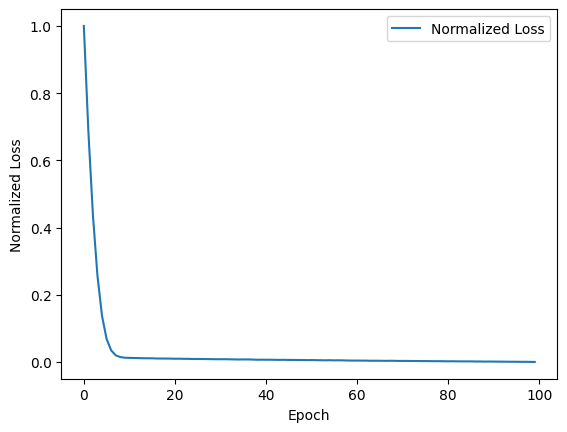

In [82]:
loss_temp = predicting_temp_model.evaluate(x_temp_test, y_temp_test)
print(f"Model Loss on Test Dataset: {loss_temp}")
# Assuming `history.history['loss']` contains your loss values
loss_temp_values = history_temp.history['loss']

# Normalize the loss values
min_temp_loss = np.min(loss_temp_values)
max_temp_loss = np.max(loss_temp_values)
normalized_temp_loss = (loss_temp_values - min_temp_loss) / (max_temp_loss - min_temp_loss)

# Plot the normalized loss values
plt.plot(normalized_temp_loss, label='Normalized Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()
plt.show()

In [83]:
def predict_future_instances(model, reduced_df_sorted, reduced_df_sorted_1, selected_sensors_list, column, num_steps):
    # Initial prediction
    predicting_data = reduced_df_sorted.groupby('Sensor ID', observed=False).nth(-1)[['Sensor ID', column]]
    temperature_input = np.array(predicting_data[column].tolist()).reshape(1, -1)
    predictions = model.predict(temperature_input)

    # Create DataFrame for the first prediction
    predicting_next_data = pd.DataFrame({
        "Sensor ID": reduced_df_sorted_1['Sensor ID'].unique(),
        "Predicted_"+column: predictions[0],
        'Actual_'+column: reduced_df_sorted_1.groupby('Sensor ID', observed=False).nth(-1)[column].tolist()
        # 'Actual_'+column:y_temp_val[0]
    })

    all_predictions = []

    all_predictions.append(predicting_next_data)
    
    for step in range(1, num_steps):
        predicting_data = predicting_next_data[predicting_next_data['Sensor ID'].isin(selected_sensors_list)]
        temperature_input = np.array(predicting_data['Predicted_'+column].tolist()).reshape(1, -1)
        
        predictions = model.predict(temperature_input)

        predicting_next_data = pd.DataFrame({
            "Sensor ID": reduced_df_sorted_1['Sensor ID'].unique(),
            "Predicted_"+column: predictions[0],
            'Actual_'+column: np.round(predicting_next_data['Predicted_'+column].tolist(),2)
            # 'Actual_'+column:y_temp_val[step]
        })
        
        # Store the current step predictions
        
        all_predictions.append(predicting_next_data)

    return all_predictions

In [84]:
predictions_temp_over_time = predict_future_instances(predicting_temp_model, reduced_df_sorted, reduced_df_sorted_1, common_sensors, 'Temperature', num_steps=102)
predictions_temp_over_time = pd.concat(predictions_temp_over_time,ignore_index=True)
predictions_temp_over_time['error_temperature'] = np.abs(predictions_temp_over_time['Predicted_Temperature'] - predictions_temp_over_time['Actual_Temperature'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

In [85]:
import os
import shutil

def error_plotting(output_dir,predictions_over_time,column, annotate):

    frames = []

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    os.makedirs(output_dir)

    for i in range(2, 102):

        temp_predict_data = predictions_over_time.groupby('Sensor ID', observed=False).nth(i - 1).reset_index()

        reconstructed_matrix = temp_predict_data[column].values.reshape(8, 7)

        plt.figure(figsize=(10, 6))
        sns.heatmap(reconstructed_matrix, annot=annotate, fmt=".2f", cmap='magma', cbar=False, xticklabels=False, yticklabels=False)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        output_file = os.path.join(output_dir, f"error_temp_heatmap_{i}.png")
        plt.savefig(output_file)
        plt.close()

        frames.append(output_file)

    return frames

In [86]:
predictions_temp_over_time

,Sensor ID,Predicted_Temperature,Actual_Temperature,error_temperature
0,047D6,19.161726,19.95,0.788274
1,0475D,19.248745,19.75,0.501255
2,0479B,18.884832,23.30,4.415168
3,047BB,18.954355,15.20,3.754355
4,04754,18.962723,14.20,4.762723
...,...,...,...,...
5707,04791,18.132778,19.73,1.597222
5708,04802,19.014643,19.50,0.485357
5709,047C5,18.942091,21.07,2.127909
5710,04796,18.630432,19.79,1.159568


In [87]:
import cv2

def video_generation(frames, video_output):
    frame = cv2.imread(frames[0])
    height, width, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    video = cv2.VideoWriter(video_output, fourcc, 24.0, (width, height))

    prev_frame = cv2.imread(frames[0])

    for frame_path in frames[1:]:
        next_frame = cv2.imread(frame_path)
        
        for i in range(1, 10):
            alpha = i / 10.0
            interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
            video.write(interpolated_frame)

        prev_frame = next_frame

    video.release()
    cv2.destroyAllWindows()

    return f"Video saved as: {video_output}"

In [88]:
error_temp_toutput_dir = 'error_frames/temperature'
error_temp_frames = error_plotting(error_temp_toutput_dir,predictions_temp_over_time,'error_temperature', True)
video_generation(error_temp_frames,'Error_temp_video.mp4')

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


'Video saved as: Error_temp_video.mp4'

### Humidity

In [89]:
x_humid, y_humid = standerdizing_data(reduced_df_sorted,reduced_df_sorted_1,'Humidity')

x_humid = shuffle_data(x_humid)
y_humid = shuffle_data(y_humid)

In [90]:
x_humid

array([[75.9 , 62.8 , 56.91, ..., 89.5 , 51.4 , 74.8 ],
       [90.  , 81.9 , 82.3 , ..., 76.5 , 81.6 , 75.5 ],
       [37.1 , 51.7 , 82.2 , ..., 79.9 , 46.1 , 37.9 ],
       ...,
       [71.9 , 37.4 , 77.1 , ..., 68.9 , 85.9 , 38.8 ],
       [36.1 , 83.2 , 43.5 , ..., 55.2 , 33.4 , 47.  ],
       [41.5 , 49.6 , 37.1 , ..., 62.  , 81.5 , 63.7 ]])

In [91]:
# Split the data into 70% training+validation and 30% test set
x_humid_train_val, x_humid_test, y_humid_train_val, y_humid_test = train_test_split(x_humid, y_humid, test_size=0.3, random_state=0)

# Now split the training+validation set into 70% training and 30% validation set
x_humid_train, x_humid_val, y_humid_train, y_humid_val = train_test_split(x_humid_train_val, y_humid_train_val, test_size=0.3, random_state=0)

In [92]:
predicting_humid_model = neural_network_model(x_humid, y_humid)

In [93]:
history_humid = predicting_humid_model.fit(x_humid_train, y_humid_train, epochs=100, batch_size=16, validation_data=(x_humid_val, y_humid_val))

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4742.6816 - val_loss: 4721.6499
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4370.2114 - val_loss: 4247.6528
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3945.9209 - val_loss: 3542.5359
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3515.8833 - val_loss: 2984.7944
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3096.8860 - val_loss: 2587.5513
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2698.5073 - val_loss: 2257.3816
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2311.3914 - val_loss: 1966.6725
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1949.3734 - val_loss: 1702.7186
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1628.6921 - val_loss: 1494.5112
Epoch 10/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1351.3599 - val_loss: 1313.2716
Epoch 11/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1101.06

In [94]:
loss_humid = predicting_humid_model.evaluate(x_humid_test, y_humid_test)
print(f"Model Loss on Test Dataset: {loss_humid}")
# Assuming `history.history['loss']` contains your loss values
loss_humid_values = history_humid.history['loss']

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1403.6700
Model Loss on Test Dataset: 1624.6048583984375


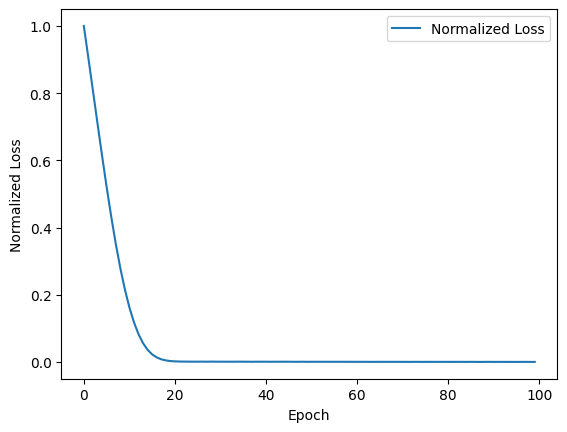

In [95]:
# Normalize the loss values
min_humid_loss = np.min(loss_humid_values)
max_humid_loss = np.max(loss_humid_values)
normalized_humid_loss = (loss_humid_values - min_humid_loss) / (max_humid_loss - min_humid_loss)

# Plot the normalized loss values
plt.plot(normalized_humid_loss, label='Normalized Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()
plt.show()

In [96]:
predictions_humid_over_time = predict_future_instances(predicting_humid_model, reduced_df_sorted, reduced_df_sorted_1, common_sensors, 'Humidity', num_steps=102)
predictions_humid_over_time = pd.concat(predictions_humid_over_time,ignore_index=True)
predictions_humid_over_time['error_Humidity'] = np.abs(predictions_humid_over_time['Predicted_Humidity'] - predictions_humid_over_time['Actual_Humidity'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

In [97]:
predictions_humid_over_time

,Sensor ID,Predicted_Humidity,Actual_Humidity,error_Humidity
0,047D6,68.927406,54.00,14.927406
1,0475D,66.936058,61.60,5.336058
2,0479B,66.547363,50.90,15.647363
3,047BB,68.093628,79.10,11.006372
4,04754,65.723587,84.80,19.076413
...,...,...,...,...
5707,04791,71.079353,70.31,0.769353
5708,04802,71.053200,69.71,1.343200
5709,047C5,70.711349,70.06,0.651349
5710,04796,71.049484,70.46,0.589484


In [98]:

error_humid_output_dir = 'error_frames/Humidity'
error_humid_frames = error_plotting(error_humid_output_dir,predictions_humid_over_time,'error_Humidity', True)
video_generation(error_humid_frames,'Error_humid_video.mp4')

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


'Video saved as: Error_humid_video.mp4'

## Sensor positioning :

In [99]:
with open('sensor_placement.json','r') as sensor:
    data = json.load(sensor)

In [100]:
data.keys()

dict_keys(['047D6', '0475D', '0479B', '047BB', '04754', '047CE', '047CB', '0474D', '04757', '047AA', '047C2', '047F7', '04756', '047C1', '0478A', '04762', '04768', '04789', '04773', '047B7', '047D3', '047B8', '04750', '0480E', '047DD', '047D7', '047A8', '047BA', '047B2', '04804', '04763', '047B6', '047C4', '047D2', '04765', '047C8', '0477F', '0478C', '047D4', '0479E', '047C9', '047C7', '047CA', '0476E', '0478E', '0475C', '04787', '047AD', '047BC', '0475A', '04771', '04791', '04802', '047C5', '04796', '047CD'])

In [101]:
common_sensor_positions = [data[i] if i in data else "no values found" for i in common_sensors]
Temp_sensor_positions = [data[i] if i in data else "no values found" for i in retained_sensor_ids]
Humid_sensor_positions = [data[i] if i in data else "no values found" for i in retained_sensor_Humid]

In [102]:
# Convert positions to DataFrames
df_common = pd.DataFrame(common_sensor_positions, columns=['Y', 'X'])
df_temp = pd.DataFrame(Temp_sensor_positions, columns=['Y', 'X'])
df_humid = pd.DataFrame(Humid_sensor_positions, columns=['Y', 'X'])

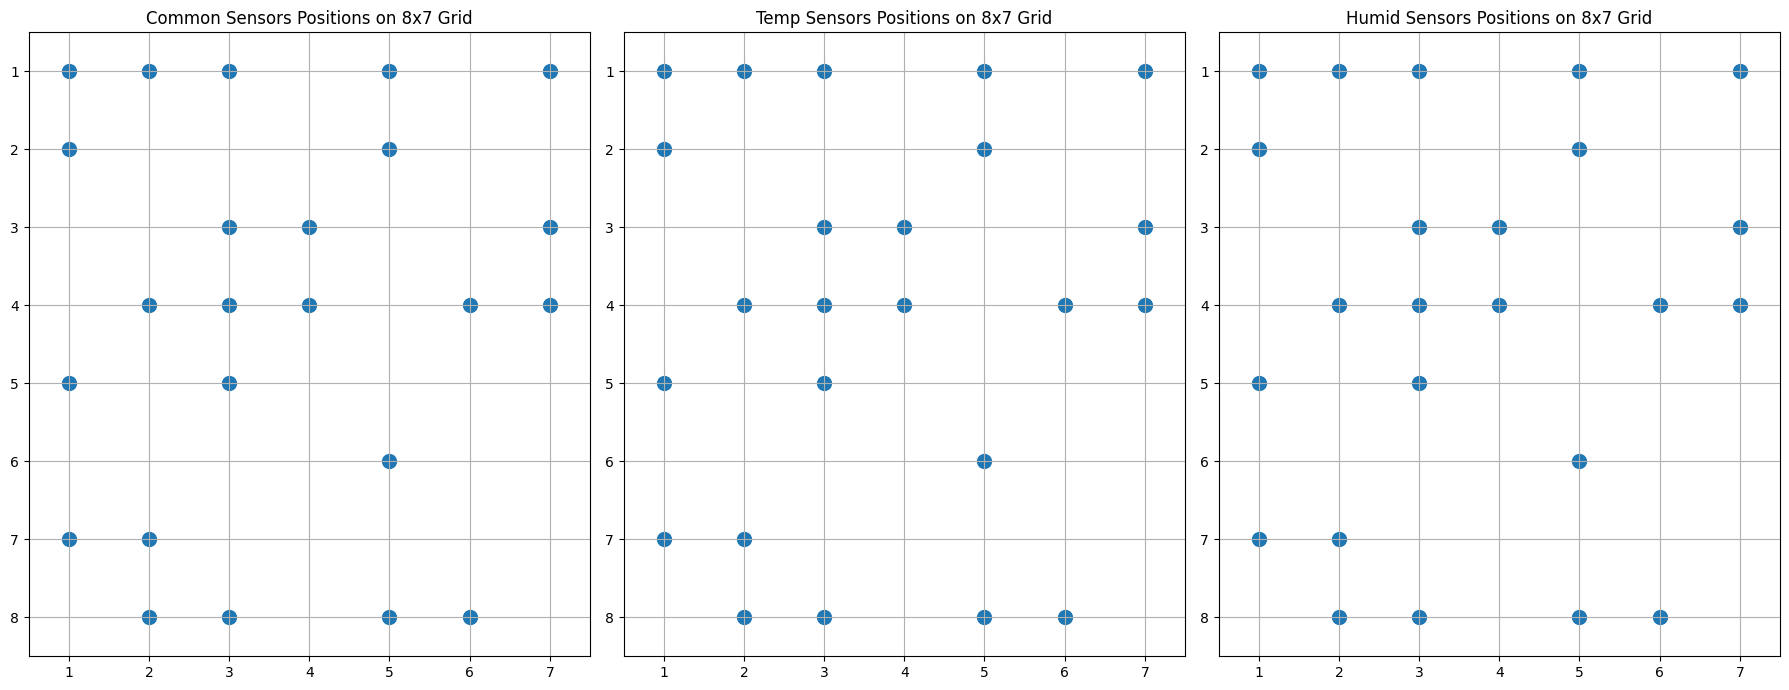

In [103]:
# Plotting the positions in subplots
plt.figure(figsize=(18, 7))

# Common Sensors Plot
plt.subplot(1, 3, 1)
plt.scatter(df_common['X'], df_common['Y'], s=100)
plt.xlim(0.5, 7.5)
plt.ylim(0.5, 8.5)
plt.gca().invert_yaxis()  # Invert y-axis to match grid orientation
plt.xticks(range(1, 8))
plt.yticks(range(1, 9))
plt.grid(True)
plt.title('Common Sensors Positions on 8x7 Grid')

# Temp Sensors Plot
plt.subplot(1, 3, 2)
plt.scatter(df_temp['X'], df_temp['Y'], s=100)
plt.xlim(0.5, 7.5)
plt.ylim(0.5, 8.5)
plt.gca().invert_yaxis()  # Invert y-axis to match grid orientation
plt.xticks(range(1, 8))
plt.yticks(range(1, 9))
plt.grid(True)
plt.title('Temp Sensors Positions on 8x7 Grid')

# Humid Sensors Plot
plt.subplot(1, 3, 3)
plt.scatter(df_humid['X'], df_humid['Y'], s=100)
plt.xlim(0.5, 7.5)
plt.ylim(0.5, 8.5)
plt.gca().invert_yaxis()  # Invert y-axis to match grid orientation
plt.xticks(range(1, 8))
plt.yticks(range(1, 9))
plt.grid(True)
plt.title('Humid Sensors Positions on 8x7 Grid')

plt.tight_layout()
plt.show()

In [104]:
humid_output_dir = 'Reconstructed_heatmaps/humidity'
predicted_humid_frames = error_plotting(humid_output_dir,predictions_humid_over_time,'Predicted_Humidity', False)
video_generation(predicted_humid_frames,'Reconstructed_humid_heatmap_video.mp4')

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


'Video saved as: Reconstructed_humid_heatmap_video.mp4'

In [105]:
# Ensure the correct directory is used for temperature frames
temp_output_dir = 'Reconstructed_heatmaps/temperature'

# Generate predicted temperature frames
predicted_temp_frames = error_plotting(temp_output_dir, predictions_temp_over_time, 'Predicted_Temperature', False)

# Generate video for temperature predictions
video_generation(predicted_temp_frames, 'Reconstructed_temp_heatmap_video.mp4')

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


'Video saved as: Reconstructed_temp_heatmap_video.mp4'

In [107]:
from skimage.metrics import structural_similarity as ssim
from scipy import stats

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def compare_frames(frame1, frame2):
    frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(frame1_gray, frame2_gray, full=True)
    return score

def compare_videos(video1_frames, video2_frames):
    if len(video1_frames) != len(video2_frames):
        print("Warning: Videos have different number of frames")
    
    similarity_scores = []
    for f1, f2 in zip(video1_frames, video2_frames):
        score = compare_frames(f1, f2)
        similarity_scores.append(score)
    
    return similarity_scores

def overall_similarity(similarity_scores):
    return np.mean(similarity_scores)

def perform_statistical_tests(similarity_scores):
    # Perform a one-sample t-test on similarity scores
    t_statistic, p_value_ttest = stats.ttest_1samp(similarity_scores, 0)
    
    # Perform a Wilcoxon signed-rank test
    w_statistic, p_value_wilcoxon = stats.wilcoxon(similarity_scores - np.mean(similarity_scores))
    
    # Perform a Kolmogorov-Smirnov test
    d_statistic, p_value_ks = stats.kstest(similarity_scores, 'norm', args=(np.mean(similarity_scores), np.std(similarity_scores)))
    
    return {
        't-test': (t_statistic, p_value_ttest),
        'Wilcoxon signed-rank test': (w_statistic, p_value_wilcoxon),
        'Kolmogorov-Smirnov test': (d_statistic, p_value_ks)
    }
def get_video_info(file_path):
    video = cv2.VideoCapture(file_path)

    if not video.isOpened():
        raise ValueError("Error opening video file")

    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video.release()

    return frame_count, width, height



In [108]:
get_video_info('Humidity_Heatmap_video.mp4')


(891, 1000, 600)

In [109]:
get_video_info('Temperature_Heatmap_video.mp4')

(891, 1000, 600)

In [110]:
get_video_info('Reconstructed_humid_heatmapvideo.mp4')

(891, 1000, 600)

In [111]:
get_video_info('Reconstructed_Temp_heatmap_video.mp4')

(891, 1000, 600)

In [112]:

# Paths to your video files
video1_path = 'Humidity_Heatmap_video.mp4'
video2_path = 'Reconstructed_humid_heatmap_video.mp4'

# Extract frames
video1_frames = extract_frames(video1_path)
video2_frames = extract_frames(video2_path)

# Compare videos
similarity_scores = compare_videos(video1_frames, video2_frames)

# Compute overall similarity
overall_score = overall_similarity(similarity_scores)

# Perform statistical tests
statistical_results = perform_statistical_tests(similarity_scores)

print(f"Overall similarity score for Humidity: {overall_score}")
print(f"T-test: T-statistic for Humidity = {statistical_results['t-test'][0]}, P-value = {statistical_results['t-test'][1]}")
print(f"Wilcoxon signed-rank test for Humidity: Statistic = {statistical_results['Wilcoxon signed-rank test'][0]}, P-value = {statistical_results['Wilcoxon signed-rank test'][1]}")
print(f"Kolmogorov-Smirnov test for Humidity: Statistic = {statistical_results['Kolmogorov-Smirnov test'][0]}, P-value = {statistical_results['Kolmogorov-Smirnov test'][1]}")


Overall similarity score for Temperature: 0.6681909315698431
T-test: T-statistic for Temperature = 529.1907328123029, P-value = 0.0
Wilcoxon signed-rank test for Temperature: Statistic = 188423.0, P-value = 0.18137569732071945
Kolmogorov-Smirnov test for Temperature: Statistic = 0.07950850419263356, P-value = 2.3984266293303176e-05


In [113]:

# Paths to your video files
video1_path = 'Temperature_Heatmap_video.mp4'
video2_path = 'Reconstructed_Temp_heatmap_video.mp4'

# Extract frames
video1_frames = extract_frames(video1_path)
video2_frames = extract_frames(video2_path)

# Compare videos
similarity_scores = compare_videos(video1_frames, video2_frames)

# Compute overall similarity
overall_score = overall_similarity(similarity_scores)

# Perform statistical tests
statistical_results = perform_statistical_tests(similarity_scores)

print(f"Overall similarity score for Temperature: {overall_score}")
print(f"T-test: T-statistic for Temperature = {statistical_results['t-test'][0]}, P-value = {statistical_results['t-test'][1]}")
print(f"Wilcoxon signed-rank test for Temperature: Statistic = {statistical_results['Wilcoxon signed-rank test'][0]}, P-value = {statistical_results['Wilcoxon signed-rank test'][1]}")
print(f"Kolmogorov-Smirnov test for Temperature: Statistic = {statistical_results['Kolmogorov-Smirnov test'][0]}, P-value = {statistical_results['Kolmogorov-Smirnov test'][1]}")


Overall similarity score for Temperature: 0.6224657702760876
T-test: T-statistic for Temperature = 359.4989670336603, P-value = 0.0
Wilcoxon signed-rank test for Temperature: Statistic = 191394.0, P-value = 0.34216957336696685
Kolmogorov-Smirnov test for Temperature: Statistic = 0.03723931148576298, P-value = 0.16470414656936205
